In [56]:
import rosbag
from geometry_msgs.msg import Point
import pandas as pd
import matplotlib.pyplot as plt
import rospy
import numpy as np

In [57]:
bag = rosbag.Bag('/home/uware/rosbags/_2022-02-21-11-12-03.bag')
topic = '/tf'

rows = []

# create variables
target = 'distance'
true_value = 'true_distance'


for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)
# df

In [58]:
# calculate relative time in seconds by finding the difference between time instances
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance
0,0.000000,1.540828
1,0.100539,1.544104
2,0.190374,1.560746
3,0.282790,1.584294
4,0.378646,1.586674
...,...,...
566,26.838087,0.525557
567,26.873688,0.522651
568,26.908928,0.526820
569,26.945567,0.525514


<AxesSubplot:xlabel='relative_time'>

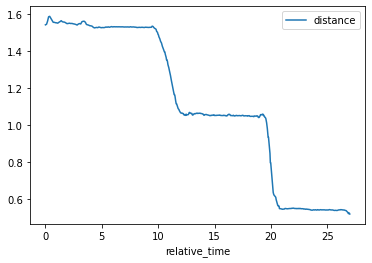

In [59]:
# initial graph
df.plot(x='relative_time', y=target)

### segment by percentage change

In [60]:
# Periods to shift for forming percent change
period = 5

# pct_change to take into account
change_amount = .001


df_filtered_by_change = df.loc[df[target].pct_change(periods=period)>change_amount]

In [61]:
df_filtered_by_change.count()

relative_time    120
distance         120
dtype: int64

<AxesSubplot:xlabel='relative_time', ylabel='distance'>

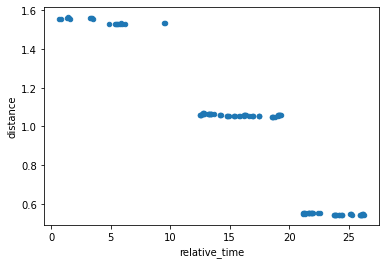

In [62]:
df_filtered_by_change.plot.scatter(x='relative_time', y=target)

In [63]:
# input values in meters
input_vals = [1.5,1,0.5]

# segmenting
df_filtered_by_change[true_value] = pd.cut(df_filtered_by_change[target], bins=len(input_vals), labels=input_vals[::-1]) # input reversed
df_filtered_by_change

/tmp/ipykernel_7424/2234543779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_by_change[true_value] = pd.cut(df_filtered_by_change[target], bins=len(input_vals), labels=input_vals[::-1]) # input reversed


,relative_time,distance,true_distance
5,0.690813,1.554469,1.5
6,0.791631,1.554393,1.5
11,1.301386,1.558417,1.5
12,1.400859,1.563154,1.5
13,1.500796,1.557410,1.5
...,...,...,...
547,26.130603,0.543427,0.5
548,26.167745,0.544580,0.5
549,26.204765,0.544580,0.5
550,26.241443,0.544948,0.5


In [64]:
df_filtered_by_change['error'] =  df_filtered_by_change.apply(lambda row: row[true_value] - row[target], axis=1)
df_filtered_by_change

/tmp/ipykernel_7424/2962303063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_by_change['error'] =  df_filtered_by_change.apply(lambda row: row[true_value] - row[target], axis=1)


,relative_time,distance,true_distance,error
5,0.690813,1.554469,1.5,-0.054469
6,0.791631,1.554393,1.5,-0.054393
11,1.301386,1.558417,1.5,-0.058417
12,1.400859,1.563154,1.5,-0.063154
13,1.500796,1.557410,1.5,-0.057410
...,...,...,...,...
547,26.130603,0.543427,0.5,-0.043427
548,26.167745,0.544580,0.5,-0.044580
549,26.204765,0.544580,0.5,-0.044580
550,26.241443,0.544948,0.5,-0.044948


In [65]:
df_filtered_by_change.groupby(true_value).head(2)

,relative_time,distance,true_distance,error
5,0.690813,1.554469,1.5,-0.054469
6,0.791631,1.554393,1.5,-0.054393
168,12.481877,1.059241,1.0,-0.059241
169,12.525551,1.056259,1.0,-0.056259
417,21.166948,0.547607,0.5,-0.047607
418,21.207930,0.549685,0.5,-0.049685


In [66]:
df_filtered_by_change.groupby(true_value).error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
0.5,42.0,-0.046622,0.003610,-0.052749,-0.050565,-0.044580,-0.043551,-0.041792
1.0,57.0,-0.057205,0.005024,-0.068637,-0.061244,-0.056761,-0.053472,-0.048483
1.5,21.0,-0.043074,0.014412,-0.063154,-0.057260,-0.033689,-0.029554,-0.027393
